# Objectives
1. Reformat the audio into the format that will be used in production - overlapping array segments of audio files.
1. Reformat the audio labels to match the desired production outcome - binary value indicating if the array segment contains a soccer juggle or not.

# Assumptions
* Data labels are within 5k indices of the true juggle signal peak
* The largest signal peak within 5k indices of the original data label is the true juggle signal

# Project Set Up

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import glob
import librosa
import os
import sys
import time

sys.path.append(os.getcwd())

import python_utils

print(sys.version)
print(pd.__version__)
print(np.__version__)
print(librosa.__version__)

3.9.21 (main, Dec  3 2024, 17:50:13) 
[GCC 13.3.0]
2.2.3
2.0.2
0.11.0


## Global Variables
- Length of ball signal is ~0.2 seconds.
- Use 0.3 seconds for window length to be safe.
- Window Length = 0.3 * Sample Rate
- Want Window Length to be even so 1/2 Window Length is still an integer. This will allow windows to overlap nicely

In [3]:
START_TIME = time.time()
SAMPLE_RATE = 22050
FRAME_RATE = 30
LABEL_CORRECTION_SEARCH_WINDOW = 2500
LABEL_PATH = os.path.join("data", "labels_timestamp")
AUDIO_PATH = os.path.join("data", "audio_files")
PREPROCESSED_DATA_PATH = os.path.join("data", "preprocessed_data")
WINDOW_SIZE_SECONDS = 0.3
WINDOW_OVERLAP = 0.75

In [4]:
def round_up_to_even(number):
    """Rounds a number up to the next highest even number.

    Args:
        number: The number to round.

    Returns:
        The next highest even number.
    """
    if number % 2 == 0:
        return int(number)  # If already even, return as int
    else:
        return int(number) + 1


WINDOW_SIZE = round_up_to_even(WINDOW_SIZE_SECONDS * SAMPLE_RATE)

print(WINDOW_SIZE)

6616


## Set up Data Tracker Container

In [5]:
audio_filenames = glob.glob(os.path.join(AUDIO_PATH, "*.wav"))
base_names = [filename.split('/')[-1].replace('_audio.wav','') for filename in audio_filenames]
tracker = {
    base_names[i]: {
        "audio_filename": audio_filenames[i],
        "labels_filename": os.path.join(LABEL_PATH, base_names[i] + '_labels.txt'),
    }
    for i in range(len(base_names))
}


python_utils.custom_print(tracker)

{
  'PXL_20250320_200743743.TS_1': {
    'audio_filename': 'data/audio_files/PXL_20250320_200743743.TS_1_audio.wav'
    'labels_filename': 'data/labels_timestamp/PXL_20250320_200743743.TS_1_labels.txt'
  }
  'PXL_20250320_200905850.TS_1': {
    'audio_filename': 'data/audio_files/PXL_20250320_200905850.TS_1_audio.wav'
    'labels_filename': 'data/labels_timestamp/PXL_20250320_200905850.TS_1_labels.txt'
  }
  'PXL_20250222_013140200.TS_1': {
    'audio_filename': 'data/audio_files/PXL_20250222_013140200.TS_1_audio.wav'
    'labels_filename': 'data/labels_timestamp/PXL_20250222_013140200.TS_1_labels.txt'
  }
  'PXL_20250320_200905850.TS_2': {
    'audio_filename': 'data/audio_files/PXL_20250320_200905850.TS_2_audio.wav'
    'labels_filename': 'data/labels_timestamp/PXL_20250320_200905850.TS_2_labels.txt'
  }
  'PXL_20250312_215759199.TS_1': {
    'audio_filename': 'data/audio_files/PXL_20250312_215759199.TS_1_audio.wav'
    'labels_filename': 'data/labels_timestamp/PXL_20250312_215759199

# Load Data
* Labels (`labels_raw`) are (manually created) timestamps of approximately when a juggle was made
* Audio data (`audio_values`) are loaded as 1D numpy arrays
  * Each index is a sample of the audio data at the `SAMPLE_RATE`
  * Each value is the audio amplitude at that index

In [6]:
for base_name in tracker:
  tracker[base_name]["labels_raw"] = list()
  with open(tracker[base_name]["labels_filename"], 'r') as file:
      for line in file:
        tracker[base_name]["labels_raw"].append(line.strip())
  tracker[base_name]["audio_values"], _ = librosa.load(tracker[base_name]["audio_filename"], sr=SAMPLE_RATE)


python_utils.custom_print(tracker)

{
  'PXL_20250320_200743743.TS_1': {
    'audio_filename': 'data/audio_files/PXL_20250320_200743743.TS_1_audio.wav'
    'labels_filename': 'data/labels_timestamp/PXL_20250320_200743743.TS_1_labels.txt'
    'labels_raw': ['00:00:00;28', '00:00:01;16', '00:00:02;04', '00:00:02;18', '00:00:02;29', '00:00:03;12', '00:00:03;27', '00:00:04;15', '00:00:05;09', '00:00:05;25', ...]
    'audio_values': array([-3.2472519e-10, -3.0918512e-10,  1.0859985e-10, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)
  }
  'PXL_20250320_200905850.TS_1': {
    'audio_filename': 'data/audio_files/PXL_20250320_200905850.TS_1_audio.wav'
    'labels_filename': 'data/labels_timestamp/PXL_20250320_200905850.TS_1_labels.txt'
    'labels_raw': ['00:00:01;03', '00:00:01;21', '00:00:02;08', '00:00:02;25', '00:00:03;17', '00:00:04;03', '00:00:04;23', '00:00:05;09', '00:00:06;00', '00:00:06;18', ...]
    'audio_values': array([-2.9035892e-11,  2.6896084e-11, -4.0351028e-11, ...,
        4.88686

# Transform Data

## Transform Labels

### Reshape
* Labels are transformed into arrays that match the length of the audio data
  * Value is 1 where a soccer juggle occurs, 0 otherwise

In [7]:
def olive_timestamp_to_seconds(timestamp: str, frame_rate: int) -> float:
    """HH:MM:SS;FF -> seconds"""
    try:
        hours, minutes, seconds_frames = timestamp.split(':')
        seconds, frames = seconds_frames.split(';')
        return (
            float(hours) * 60 * 60  # Hours
            + float(minutes) * 60  # Minutes
            + float(seconds)  # Seconds
            + float(frames) / frame_rate  # Frames
        )
    except ValueError:
        return np.nan
    except IndexError:
        return np.nan


def transform_labels_timestamp_to_vector(labels_raw: list, sample_rate: int, frame_rate: int, data_size: int) -> list:
  labels = np.zeros(data_size)
  for raw_label in labels_raw:
    labels[
      int(
        olive_timestamp_to_seconds(
          timestamp=raw_label,
          frame_rate=frame_rate,
        ) * sample_rate
      )
    ] = 1
  return labels


# Test transform_audio
print(transform_labels_timestamp_to_vector(
      labels_raw=['00:00:01;00', '00:00:02;00', '00:00:05;00'],
      sample_rate=1,
      frame_rate=1,
      data_size=20,
))

[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
for base_name in tracker:
  # Transform labels to match raw data array format
  tracker[base_name]["labels_full_array"] = transform_labels_timestamp_to_vector(
      labels_raw=tracker[base_name]["labels_raw"],
      sample_rate=SAMPLE_RATE,
      frame_rate=FRAME_RATE,
      data_size=len(tracker[base_name]["audio_values"])
  )
  # Check labels
  print(base_name)
  if np.any(np.isnan(tracker[base_name]["labels_full_array"])):
    print("IMPORT ERROR")
  else:
    print("PASS")


python_utils.custom_print(tracker)

PXL_20250320_200743743.TS_1
PASS
PXL_20250320_200905850.TS_1
PASS
PXL_20250222_013140200.TS_1
PASS
PXL_20250320_200905850.TS_2
PASS
PXL_20250312_215759199.TS_1
PASS
PXL_20250307_005733826.TS_1
PASS
PXL_20250223_164321190.TS_1
PASS
PXL_20250222_012947893.TS_1
PASS
PXL_20250222_012947893.TS_2
PASS
PXL_20250307_005644623.TS_1
PASS
PXL_20250223_164224211.TS_1
PASS
PXL_20250320_200642835.TS_1
PASS
PXL_20250223_164250127.TS_1
PASS
{
  'PXL_20250320_200743743.TS_1': {
    'audio_filename': 'data/audio_files/PXL_20250320_200743743.TS_1_audio.wav'
    'labels_filename': 'data/labels_timestamp/PXL_20250320_200743743.TS_1_labels.txt'
    'labels_raw': ['00:00:00;28', '00:00:01;16', '00:00:02;04', '00:00:02;18', '00:00:02;29', '00:00:03;12', '00:00:03;27', '00:00:04;15', '00:00:05;09', '00:00:05;25', ...]
    'audio_values': array([-3.2472519e-10, -3.0918512e-10,  1.0859985e-10, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)
    'labels_full_array': array([0., 0., 0., 

### Check Labels Match Data

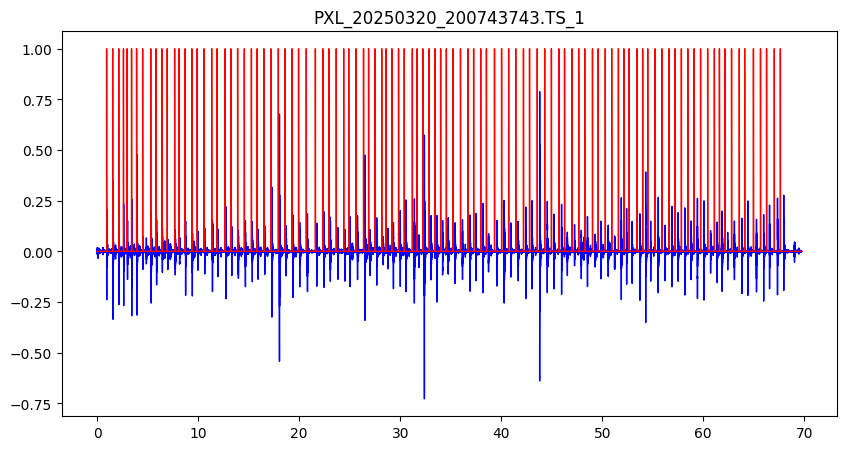

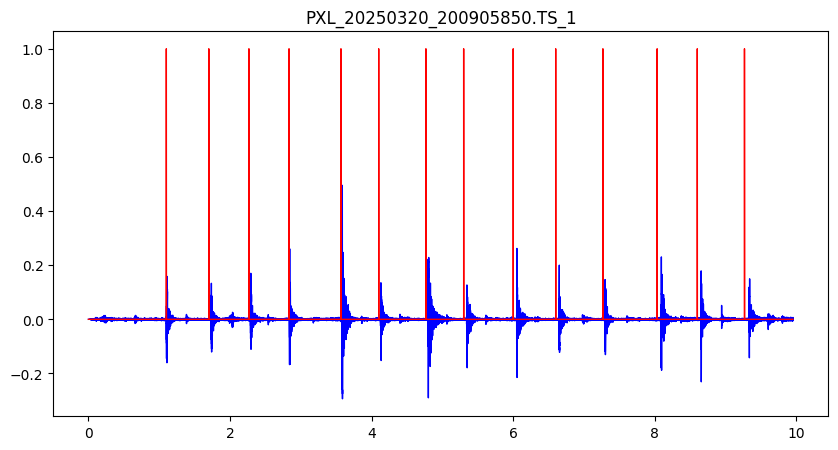

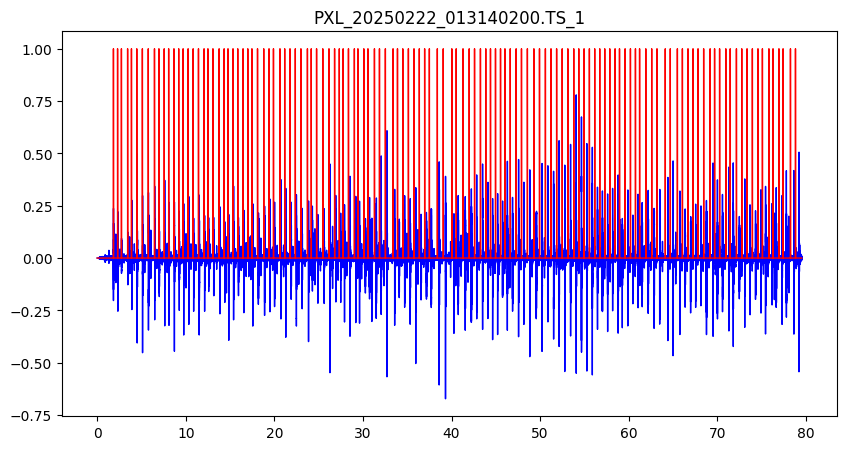

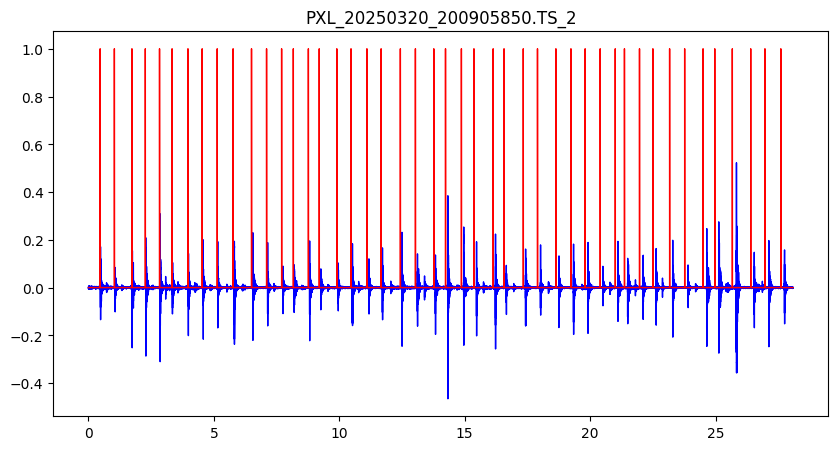

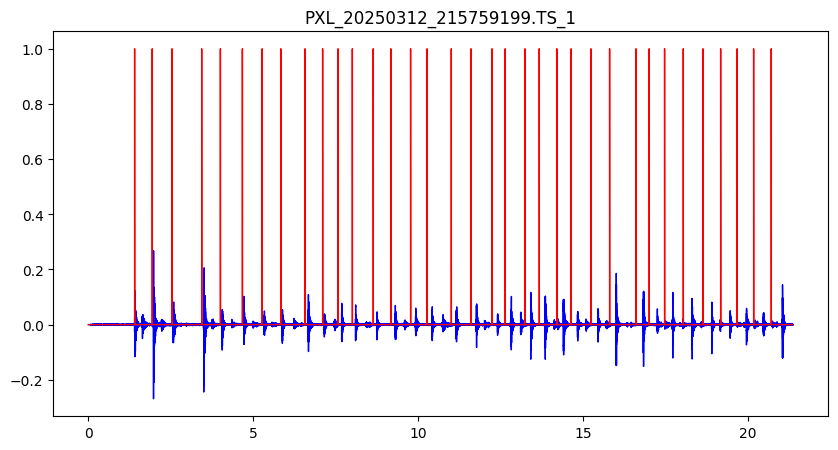

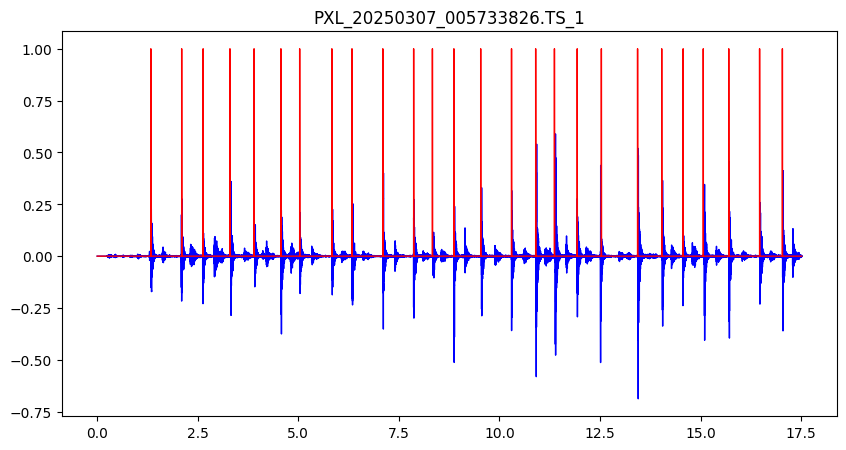

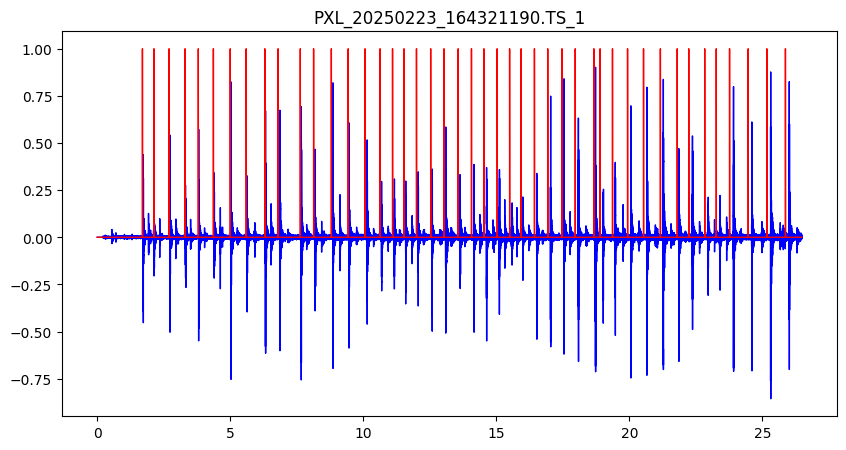

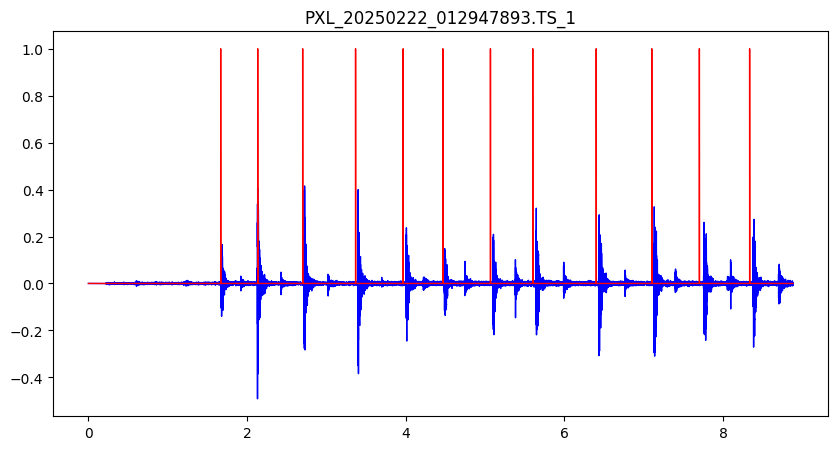

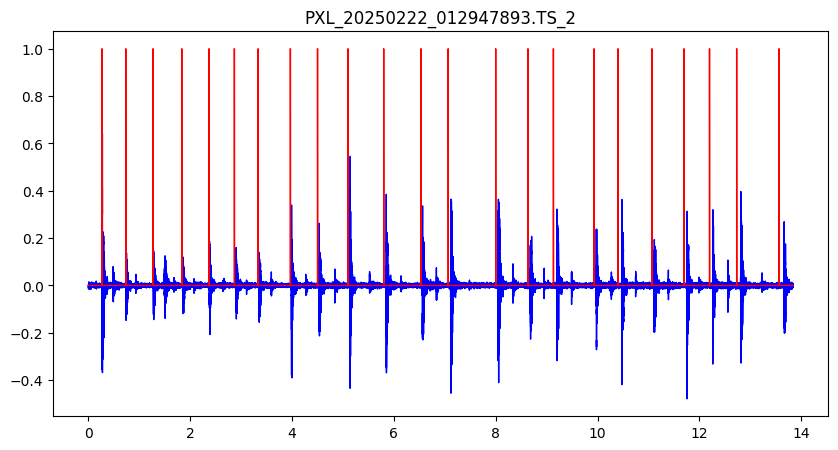

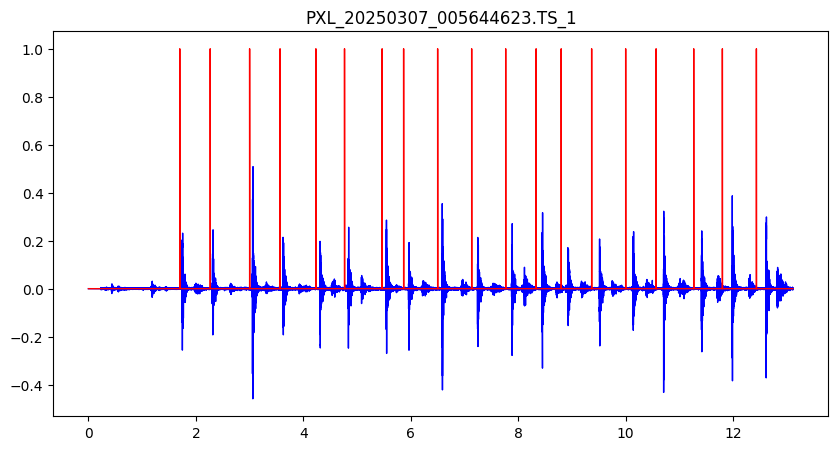

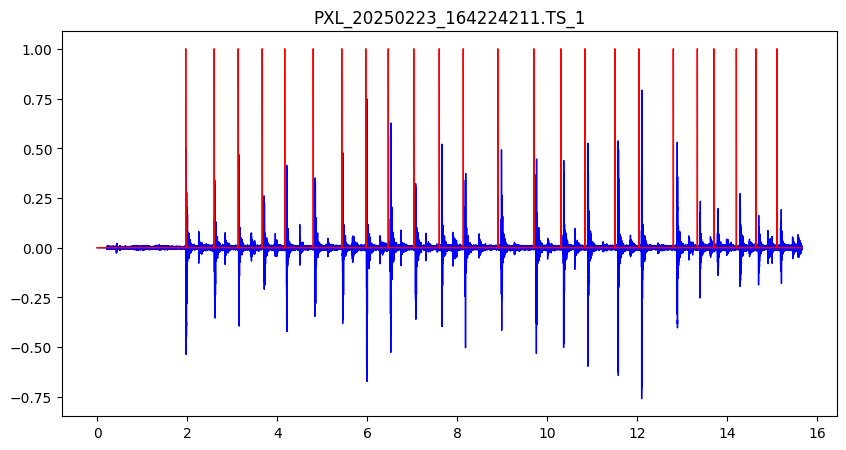

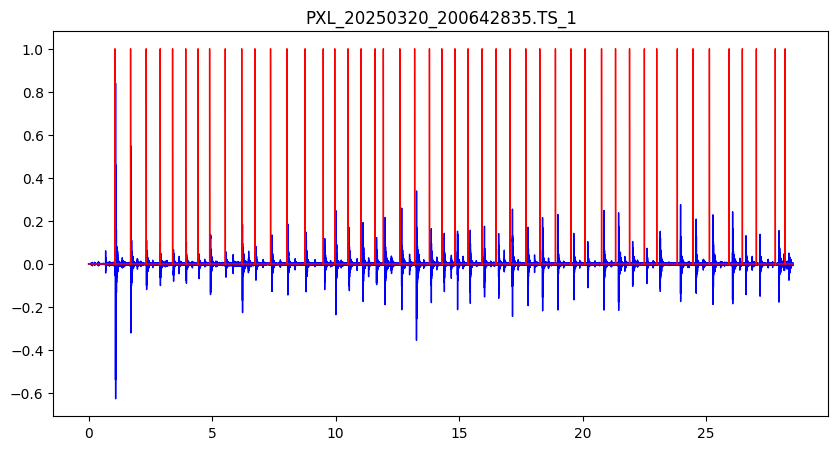

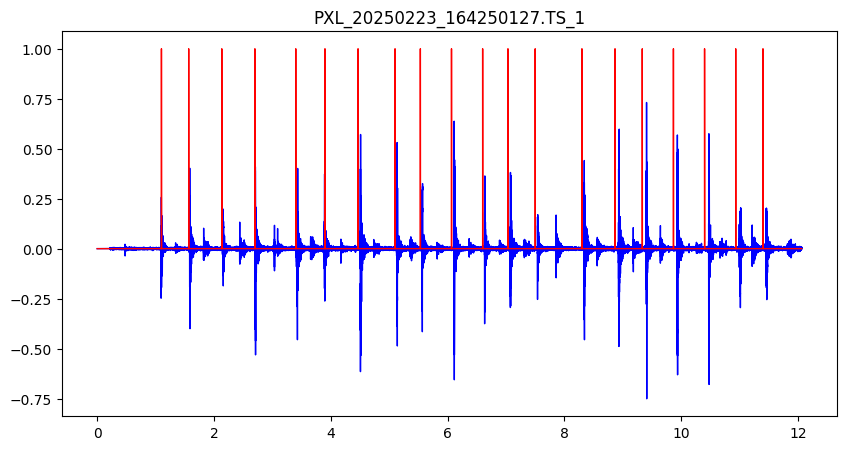

In [9]:

for base_name in tracker:
        x_axis_labels = [i / SAMPLE_RATE for i in range(len(tracker[base_name]["audio_values"]))]
        pd.Series(tracker[base_name]["audio_values"],
                index=x_axis_labels).plot(figsize=(10, 5),
                        lw=1,
                        title=base_name,
                        color='blue')
        pd.Series(tracker[base_name]["labels_full_array"],
                index=x_axis_labels).plot(
                        lw=1,
                        color='r')
        # plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        plt.show()

Notes:
* PXL_20250222_012947893.TS_1
    * At 10 seconds, the sound is the ball hitting the ground, not a juggle

### Correct Labels
- Data labels are originally collected by visually looking at a video and labeling the timestamp as close as possible to when a juggle occurs. 
    - This process is not accurate enough for downstream processes.
- The following label correction process is intended to better match each data label to the true audio signal peak for each juggle:
    - Search near the manual label for a signal maximum.
    - Move the label to the nearby signal maximum.

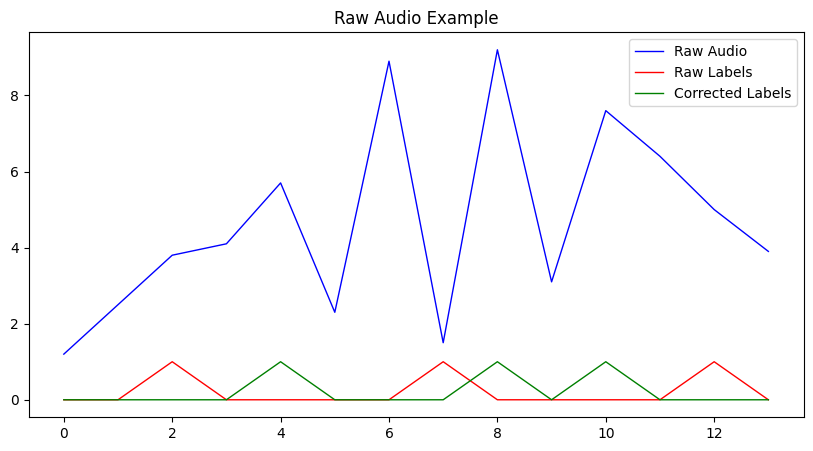

In [10]:
def correct_labels(boolean_array, real_array, search_step):
    """
    Corrects labels based on maximum values within a search window.

    Args:
        boolean_array (np.ndarray): Boolean array (1 or 0).
        real_array (np.ndarray): Real-valued array.
        search_step (int): Search window size.

    Returns:
        np.ndarray: Corrected labels array.
    """
    if len(boolean_array) != len(real_array):
        raise ValueError("Boolean and real arrays must have the same length.")
    ones_indices = np.where(boolean_array == 1)[0]
    # Check minimum distance between 1s
    for i in range(len(ones_indices)):
        for j in range(i + 1, len(ones_indices)):
            if abs(ones_indices[i] - ones_indices[j]) < search_step:
                raise ValueError("1s are too close together.")
    labels_corrected = np.zeros_like(boolean_array)
    for index in ones_indices:
        start = max(0, index - search_step)
        end = min(len(real_array), index + search_step + 1)
        search_window = real_array[start:end]
        max_index_relative = np.argmax(search_window)
        max_index_absolute = start + max_index_relative
        labels_corrected[max_index_absolute] = 1
    return labels_corrected


# Test correct_labels
boolean_array = np.array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
real_array = np.array([1.2, 2.5, 3.8, 4.1, 5.7, 2.3, 8.9, 1.5, 9.2, 3.1, 7.6, 6.4, 5.0, 3.9])
search_step = 2

corrected_labels = correct_labels(boolean_array, real_array, search_step)

pd.Series(real_array).plot(
    figsize=(10, 5),
    lw=1,
    title='Raw Audio Example',
    color='blue',
    label='Raw Audio',
)
pd.Series(boolean_array).plot(
    lw=1,
    color='red',
    label='Raw Labels',
)
pd.Series(corrected_labels).plot(
    lw=1,
    color='green',
    label='Corrected Labels',
)
plt.legend()
plt.show()

In [11]:
for base_name in tracker:
  # Correct labels - ensure the labels are located at the local maxima of the audio signal
  tracker[base_name]["labels_corrected"] = correct_labels(
      boolean_array=tracker[base_name]["labels_full_array"],
      real_array=tracker[base_name]["audio_values"],
      search_step=LABEL_CORRECTION_SEARCH_WINDOW,
  )

python_utils.custom_print(tracker)

{
  'PXL_20250320_200743743.TS_1': {
    'audio_filename': 'data/audio_files/PXL_20250320_200743743.TS_1_audio.wav'
    'labels_filename': 'data/labels_timestamp/PXL_20250320_200743743.TS_1_labels.txt'
    'labels_raw': ['00:00:00;28', '00:00:01;16', '00:00:02;04', '00:00:02;18', '00:00:02;29', '00:00:03;12', '00:00:03;27', '00:00:04;15', '00:00:05;09', '00:00:05;25', ...]
    'audio_values': array([-3.2472519e-10, -3.0918512e-10,  1.0859985e-10, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)
    'labels_full_array': array([0., 0., 0., ..., 0., 0., 0.])
    'labels_corrected': array([0., 0., 0., ..., 0., 0., 0.])
  }
  'PXL_20250320_200905850.TS_1': {
    'audio_filename': 'data/audio_files/PXL_20250320_200905850.TS_1_audio.wav'
    'labels_filename': 'data/labels_timestamp/PXL_20250320_200905850.TS_1_labels.txt'
    'labels_raw': ['00:00:01;03', '00:00:01;21', '00:00:02;08', '00:00:02;25', '00:00:03;17', '00:00:04;03', '00:00:04;23', '00:00:05;09', '00:00:

### Check Label Correction

/home/colin/code/bat_jester_model_training/.devenv/state/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


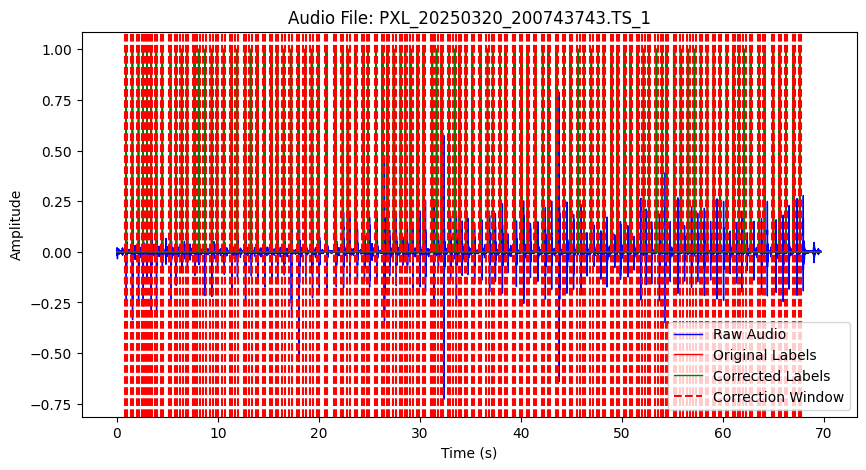

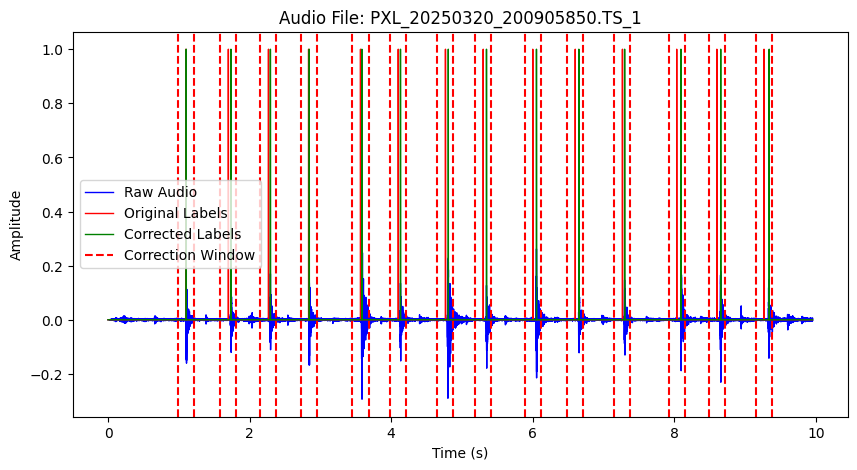

/home/colin/code/bat_jester_model_training/.devenv/state/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


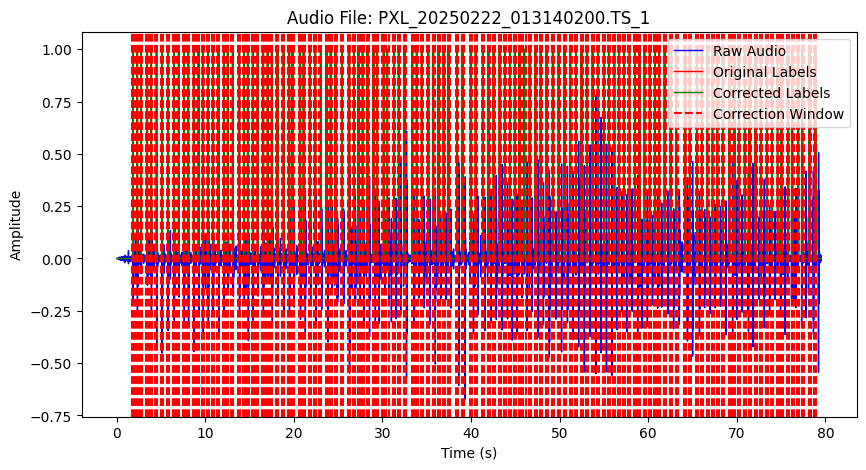

In [12]:
for base_name in list(tracker.keys())[:3]:
        x_axis_labels = [i / SAMPLE_RATE for i in range(len(tracker[base_name]["audio_values"]))]
        pd.Series(tracker[base_name]["audio_values"],
                index=x_axis_labels).plot(figsize=(10, 5),
                        lw=1,
                        title=f"Audio File: {base_name}",
                        color='blue',
                        label="Raw Audio")
        pd.Series(tracker[base_name]["labels_full_array"],
                index=x_axis_labels).plot(
                        lw=1,
                        color='r',
                        label="Original Labels")
        pd.Series(tracker[base_name]["labels_corrected"],
                index=x_axis_labels).plot(
                        lw=1,
                        color='green',
                        label="Corrected Labels")
        label_added = False
        for i in range(len(tracker[base_name]["labels_full_array"])):
                if tracker[base_name]["labels_full_array"][i] == 1:
                        if label_added:
                                plt.axvline(x=x_axis_labels[i-LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--')
                                plt.axvline(x=x_axis_labels[i+LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--')
                        else:
                                plt.axvline(x=x_axis_labels[i-LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--', label="Correction Window")
                                plt.axvline(x=x_axis_labels[i+LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--')
                                label_added = True
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()

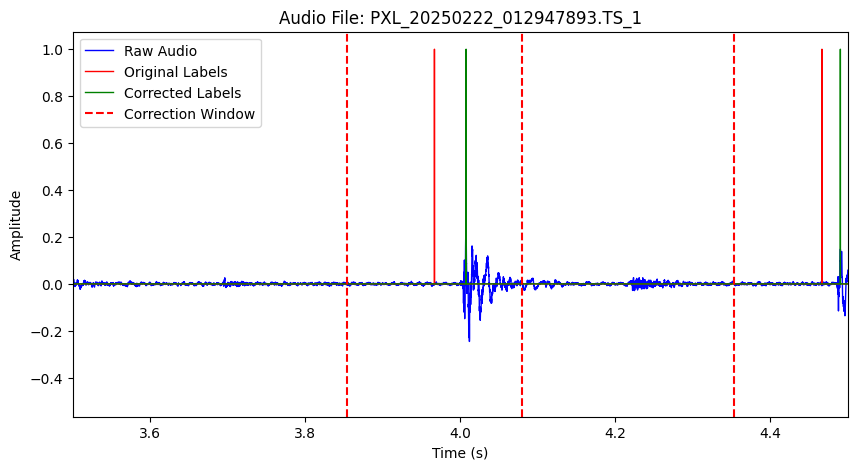

In [13]:
# Check Label Correction - Zoom In
base_name = 'PXL_20250222_012947893.TS_1'

x_axis_labels = [i / SAMPLE_RATE for i in range(len(tracker[base_name]["audio_values"]))]
pd.Series(tracker[base_name]["audio_values"],
          index=x_axis_labels).plot(figsize=(10, 5),
                  lw=1,
                  title=f"Audio File: {base_name}",
                 color='blue',
                 label='Raw Audio')
pd.Series(tracker[base_name]["labels_full_array"],
          index=x_axis_labels).plot(
                  lw=1,
                 color='r',
                 label='Original Labels')
pd.Series(tracker[base_name]["labels_corrected"],
          index=x_axis_labels).plot(
                  lw=1,
                 color='green',
                 label='Corrected Labels')
label_added = False
for i in range(len(tracker[base_name]["labels_full_array"])):
        if tracker[base_name]["labels_full_array"][i] == 1:
                if label_added:
                        plt.axvline(x=x_axis_labels[i-LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--')
                        plt.axvline(x=x_axis_labels[i+LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--')
                else:
                        plt.axvline(x=x_axis_labels[i-LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--', label="Correction Window")
                        plt.axvline(x=x_axis_labels[i+LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--')
                        label_added = True
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim((3.5, 4.5))
plt.show()

## Segment Data
- Split data into smaller, uniformly dimensioned, data segments that models can easily work with.
- Models will produce binary predictions on each of these segments.

In [14]:
# def segment_array(array_to_segment, window_size, window_overlap=0.5):
#     """
#     Segment a numpy array into chunks of specified size with a specified overlap.

#     Parameters:
#     array_to_segment (numpy.ndarray): Array to be segmented
#     window_size (int): Size of each chunk/window
#     window_overlap (float): Fraction of overlap between consecutive windows (default: 0.5, meaning 50%)

#     Returns:
#     numpy.ndarray: Array of segmented windows
#     """
#     # Input validation
#     if window_size <= 0:
#         raise ValueError("window_size must be positive")

#     if not (0 <= window_overlap < 1):
#         raise ValueError("window_overlap must be between 0 and 1")

#     # Calculate the hop length (how much to shift for each window)
#     hop_length = int(window_size * (1 - window_overlap))
#     if hop_length <= 0:
#         hop_length = 1  # Ensure at least one sample shift

#     # Get array length
#     n_samples = len(array_to_segment)

#     # Initialize list to store segments
#     segments = []

#     # Calculate start positions for each window
#     start_positions = range(0, n_samples, hop_length)

#     for start_pos in start_positions:
#         # Calculate end position
#         end_pos = start_pos + window_size

#         # If we've reached beyond the array, this is the last segment
#         if end_pos > n_samples:
#             # Extract the remaining samples
#             segment = array_to_segment[start_pos:]

#             # Pad to ensure it's of size window_size
#             padding_length = window_size - len(segment)
#             if padding_length > 0:
#                 segment = np.pad(
#                     segment, (0, padding_length), "constant", constant_values=0
#                 )

#             segments.append(segment)
#             break
#         else:
#             # Extract the full segment
#             segment = array_to_segment[start_pos:end_pos]
#             segments.append(segment)

#     # Convert list of segments to numpy array
#     return np.array(segments)

In [15]:
for base_name in tracker:
  tracker[base_name]["x_segments"] = python_utils.segment_array(
      array_to_segment=tracker[base_name]["audio_values"],
      window_size=WINDOW_SIZE,
      window_overlap=WINDOW_OVERLAP,
  )
  tracker[base_name]["y_segments"] = python_utils.segment_array(
      array_to_segment=tracker[base_name]["labels_full_array"],
      window_size=WINDOW_SIZE,
      window_overlap=WINDOW_OVERLAP,
  )


python_utils.custom_print(tracker)

{
  'PXL_20250320_200743743.TS_1': {
    'audio_filename': 'data/audio_files/PXL_20250320_200743743.TS_1_audio.wav'
    'labels_filename': 'data/labels_timestamp/PXL_20250320_200743743.TS_1_labels.txt'
    'labels_raw': ['00:00:00;28', '00:00:01;16', '00:00:02;04', '00:00:02;18', '00:00:02;29', '00:00:03;12', '00:00:03;27', '00:00:04;15', '00:00:05;09', '00:00:05;25', ...]
    'audio_values': array([-3.2472519e-10, -3.0918512e-10,  1.0859985e-10, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)
    'labels_full_array': array([0., 0., 0., ..., 0., 0., 0.])
    'labels_corrected': array([0., 0., 0., ..., 0., 0., 0.])
    'x_segments': array([[-3.2472519e-10, -3.0918512e-10,  1.0859985e-10, ...,
        -5.7908148e-04, -6.3906552e-04, -5.0799479e-04],
       [ 2.3894846e-03,  5.3066731e-04,  3.8506384e-03, ...,
         1.6897239e-03,  1.8535075e-03,  1.8345386e-03],
       [-1.9449556e-03, -1.3252422e-03,  1.0305124e-03, ...,
        -3.2116370e-03, -2.6897676e

In [16]:
# Check all segments are of equal length
for base_name in tracker:
  for i in range(len(tracker[base_name]["y_segments"])):
    if len(tracker[base_name]["y_segments"][i]) != WINDOW_SIZE:
      print(f"y for segment {i} for {base_name} is not of length {WINDOW_SIZE}.")
    if len(tracker[base_name]["x_segments"][i]) != WINDOW_SIZE:
      print(f"x for segment {i} for {base_name} is not of length {WINDOW_SIZE}.")

195804


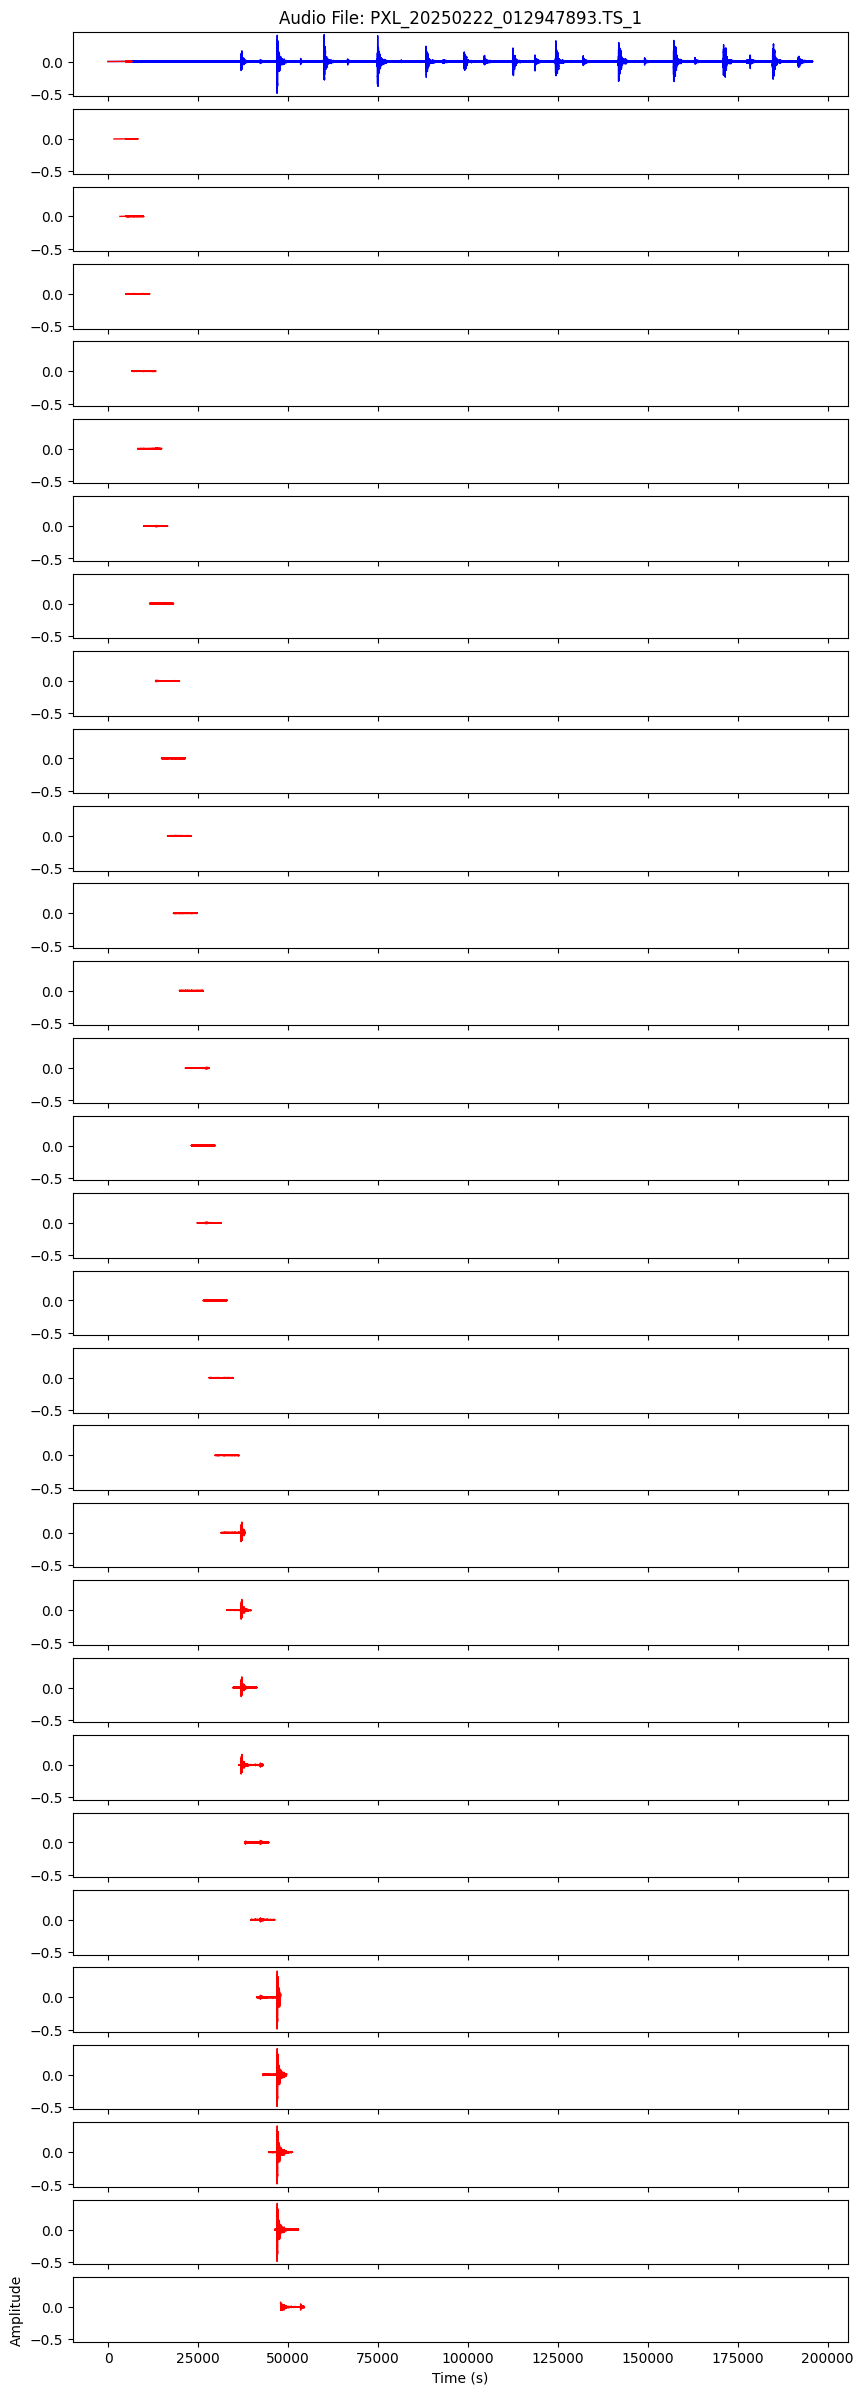

In [17]:
# Check segments are overlapped as expected
base_name = 'PXL_20250222_012947893.TS_1'
print(len(tracker[base_name]["audio_values"]))
n = 30

fig, ax = plt.subplots(ncols=1, nrows=n, sharex=True, sharey=True)
# x_axis_labels = [i / SAMPLE_RATE for i in range(len(tracker[base_name]["audio_values"]))]
pd.Series(tracker[base_name]["audio_values"]).plot(
    figsize=(10, n),
    lw=1,
    title=f"Audio File: {base_name}",
    color='blue',
    label='Raw Audio',
    ax=ax[0],
)
for i in range(n):
    segment_start_index = i * (1.0 - WINDOW_OVERLAP) * WINDOW_SIZE
    # print(segment_start_index)
    segment_index = range(int(segment_start_index), int(segment_start_index + WINDOW_SIZE))
    pd.Series(tracker[base_name]["x_segments"][i], index=segment_index).plot(
        lw=1,
        color='red',
        label='Segment',
        ax=ax[i],
    )
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.legend()
plt.show()

# Filter
- Throw out segments
    - Where two juggles occur in the same segment
    - Where the juggle occurs too close to the start or end
- These are not representative of what the model will see in production.

In [18]:
TOO_CLOSE_INDEX = int(WINDOW_SIZE / 10.0)

for base_name in tracker:
    temp_x = []
    temp_y = []
    for i in range(tracker[base_name]["y_segments"].shape[0]):
        if (
            (np.sum(tracker[base_name]["y_segments"][i]) > 1) # Two in same segment
            or (np.sum(tracker[base_name]["y_segments"][i][:TOO_CLOSE_INDEX]) > 1) # Too close to start
            or (np.sum(tracker[base_name]["y_segments"][i][-TOO_CLOSE_INDEX:]) > 1) # Too close to end
        ):
            pass
        else:
            temp_x.append(tracker[base_name]["x_segments"][i])
            temp_y.append(tracker[base_name]["y_segments"][i])
    tracker[base_name]["x_segments_filtered"] = pd.DataFrame(temp_x)
    tracker[base_name]["y_segments_filtered"] = pd.DataFrame(temp_y)
    print(base_name)
    print(tracker[base_name]["y_segments"].shape[0])
    print(tracker[base_name]["y_segments_filtered"].shape[0])

PXL_20250320_200743743.TS_1
927
927
PXL_20250320_200905850.TS_1
130
130
PXL_20250222_013140200.TS_1
1058
1058
PXL_20250320_200905850.TS_2
372
372
PXL_20250312_215759199.TS_1
282
282
PXL_20250307_005733826.TS_1
231
231
PXL_20250223_164321190.TS_1
351
350
PXL_20250222_012947893.TS_1
116
116
PXL_20250222_012947893.TS_2
182
182
PXL_20250307_005644623.TS_1
172
172
PXL_20250223_164224211.TS_1
206
206
PXL_20250320_200642835.TS_1
378
378
PXL_20250223_164250127.TS_1
158
158


## Reshape Labels
- Current
    - Labels consist of an array of 1s and 0s of the same length as each audio segment array.
- Target
    - Each audio segment gets a single 1 or 0 label. If there is a juggle in the segment, the label for that segment is 1, otherwize the label is 0.

In [19]:
for base_name in tracker:
    tracker[base_name]["y_summarized"] = tracker[base_name]["y_segments_filtered"].sum(axis=1)

In [20]:
# Check things look correct
all_true = True
for base_name in tracker:
  all_true = all_true and tracker[base_name]["x_segments_filtered"].shape[0] == tracker[base_name]["y_summarized"].shape[0]
  print(base_name, tracker[base_name]["y_summarized"][:10].values)
print(all_true)

PXL_20250320_200743743.TS_1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
PXL_20250320_200905850.TS_1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PXL_20250222_013140200.TS_1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PXL_20250320_200905850.TS_2 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
PXL_20250312_215759199.TS_1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PXL_20250307_005733826.TS_1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PXL_20250223_164321190.TS_1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PXL_20250222_012947893.TS_1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PXL_20250222_012947893.TS_2 [1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
PXL_20250307_005644623.TS_1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PXL_20250223_164224211.TS_1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PXL_20250320_200642835.TS_1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
PXL_20250223_164250127.TS_1 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True


# Save Preprocessed Data

In [21]:
for base_name in tracker:
    tracker[base_name]["x_segments_filtered"].to_csv(f"data/preprocessed_data/segments_x/{base_name}.csv", index=False, header=False)
    tracker[base_name]["y_summarized"].to_csv(f"data/preprocessed_data/summary_y/{base_name}.csv", index=False, header=False)
    pd.DataFrame(tracker[base_name]["audio_values"]).to_csv(f"data/preprocessed_data/full_array_x/{base_name}.csv", index=False, header=False)
    pd.DataFrame(tracker[base_name]["labels_corrected"]).to_csv(f"data/preprocessed_data/full_array_y/{base_name}.csv", index=False, header=False)

print(time.time()-START_TIME)

90.36597204208374
